In [1]:
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sportsml.layers.gnn.encoder.mean import MeanEncoder
from sportsml.layers.gnn.encoder.nn import NNEncoder
from sportsml.layers.gnn.predictor.nn import NNPredictor
from sportsml.models.gnn import GraphModel
from sportsml.mongo import client
from sportsml.nba.data.datamodule import NBAGraphDataModule
from sportsml.nba.data.utils import get_games

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [2]:
train = get_games(query={'SEASON': {'$gte': 2005, '$lte': 2018}})
val = get_games(query={'SEASON': 2021})
test = get_games(query={'SEASON': 2022})

In [3]:
dm = NBAGraphDataModule(df=train, val_df=val, test_df=test, split_type=None, batch_size=12, num_workers=4, recent=30)

In [4]:
trainer = pl.Trainer(
    min_epochs=15,
    max_epochs=-1,
    logger=pl.loggers.CSVLogger(save_dir='models', name='model'),
    callbacks=[
        pl.callbacks.ModelCheckpoint(monitor='val_rmse'),
        pl.callbacks.early_stopping.EarlyStopping(monitor='val_rmse', patience=5),
        pl.callbacks.LearningRateMonitor()
    ]
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
model = GraphModel(
    encoder=NNEncoder(in_feats=28, out_feats=100),
    predictor=NNPredictor(in_feats=201, dims=[100])
)

/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
  rank_zero_warn(
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'predictor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['predictor'])`.
  rank_zero_warn(


In [6]:
trainer.fit(model, dm)

/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory models/model/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name            | Type                | Params
--------------------------------------------------------
0 | encoder         | NNEncoder           | 3.0 K 
1 | predictor       | NNPredictor         | 20.9 K
2 | rmse            | MeanSquaredError    | 0     
3 | mae             | MeanAbsoluteError   | 0     
4 | accuracy_score  | MulticlassAccuracy  | 0     
5 | precision_score | MulticlassPrecision | 0     
6 | recall_score    | MulticlassRecall    | 0     
--------------------------------------------------------
23.9 K    Trainable params
0         Non-trainable params
23.9 K    Total params
0.095     Total estimated model params size (MB)
/workspace/.pyenv_mirror/user/current/lib/python3.11/sit

/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 1: 100%|██████████| 236/236 [00:11<00:00, 20.47it/s, v_num=0, train_loss=167.0, val_rmse=14.80]

/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 12:   0%|          | 0/236 [00:00<?, ?it/s, v_num=0, train_loss=104.0, val_rmse=14.70]          

Trainer was signaled to stop but the required `min_epochs=15` or `min_steps=None` has not been met. Training will continue...


Epoch 14: 100%|██████████| 236/236 [02:54<00:00,  1.35it/s, v_num=0, train_loss=102.0, val_rmse=14.70]


In [7]:
model = model.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
  rank_zero_warn(
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'predictor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['predictor'])`.
  rank_zero_warn(


In [8]:
trainer.test(model, dm, ckpt_path='best')

Restoring states from the checkpoint path at models/model/version_0/checkpoints/epoch=6-step=1652.ckpt
Loaded model weights from the checkpoint at models/model/version_0/checkpoints/epoch=6-step=1652.ckpt


Testing DataLoader 0:   7%|▋         | 1/15 [00:00<00:01,  7.18it/s]

/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Testing DataLoader 0: 100%|██████████| 15/15 [00:02<00:00,  7.47it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.6182324886322021     │
│         test_mae          │    10.426859855651855     │
│      test_precision       │    0.6182655096054077     │
│        test_recall        │    0.6182324886322021     │
│         test_rmse         │     13.23010540008545     │
└───────────────────────────┴───────────────────────────┘

[{'test_rmse': 13.23010540008545,
  'test_mae': 10.426859855651855,
  'test_accuracy': 0.6182324886322021,
  'test_precision': 0.6182655096054077,
  'test_recall': 0.6182324886322021}]

<Axes: xlabel='step'>

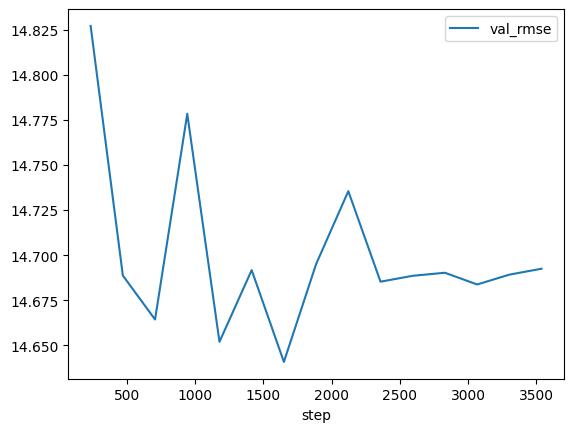

In [9]:
pd.read_csv(f'{trainer.logger.experiment.log_dir}/metrics.csv').dropna(subset=['val_rmse']).plot(x='step', y='val_rmse')

In [26]:
results = {}

for idx, date in enumerate(dm.test_ds.dates):
    g = dm.test_ds[idx]
    preds = model.predict(g).edges[g.edges()].data['home_pred']
    y = g.edata['y']
    results[date] = {'preds': preds, 'y': y, 'rmse': model.rmse(preds, y), 'acc': model.accuracy_score(preds > 0, y > 0)}

In [27]:
res_df = pd.DataFrame([{'date': date, 'rmse': res['rmse'].detach().numpy(), 'acc': res['acc'].detach().numpy()} for date, res in results.items()])

In [28]:
res_df['rmse'] = res_df['rmse'].astype(float)
res_df['acc'] = res_df['acc'].astype(float)

In [29]:
res_df['date'] = res_df['date'].astype(str).apply(lambda x: f'{x[:4]}-{x[4:6]}-{x[6:]}')

<Axes: xlabel='date'>

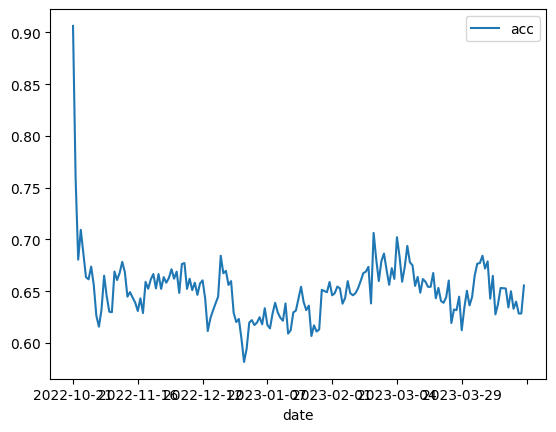

In [31]:
res_df.plot(x='date', y='acc')

In [32]:
import torch

In [35]:
g = dm.test_ds[-1]
p = model.predict(g)
u, v = p.edges()

In [36]:
preds = pd.DataFrame()
preds['u'] = u
preds['v'] = v
preds['p'] = p.edata['home_pred'].detach().numpy()

In [37]:
preds = preds.pivot_table(index='v', columns='u', values='p')

In [38]:
from sportsml.nba.data.nodes import team_abr_map

In [39]:
preds = preds.rename(index=team_abr_map, columns=team_abr_map)